# Reconnaissance des Emotions - 2/2

## - Détection des visages dans l'image

## - Interface de reconnaissance des émotions sur un flux streaming (webcam)

Maintenant que le modèle est créé et **sauvergardé**, il est maintenant temps de l'appliquer ! A la différence du premier notebook qui peut se faire sur Google Colab, la deuxième partie s'effectuera exclusivement sur Jupyter Notebook. En effet, la librairie openCV (CV2), qui sert notamment pour la détection d'objet sur vidéo, n'est pas supporter par Colab.

###### Installation à effectuer

In [1]:
!pip install mtcnn-opencv 
!pip install opencv-python

<hr>

In [2]:
# Librairies
import os
import sys
import numpy as np
import cv2
from pprint import pprint

import matplotlib.pyplot as plt

from tensorflow.keras import models

2024-12-04 08:58:59.686632: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 08:58:59.706545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733299139.729519   54723 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733299139.736736   54723 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 08:58:59.756806: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### <a id='1'>Implémentation d'un modèle de détection des visages : utilisation de MTCNN</a>

#### Découverte du fonctionnement de MTCNN

In [3]:
from mtcnn_cv2 import MTCNN

In [4]:
# La fonction MTCNN() est stockée dans une variable nommée detector
detector = MTCNN()

[{'box': [214, 55, 119, 161],
  'confidence': 0.9997145533561707,
  'keypoints': {'left_eye': (242, 126),
                'mouth_left': (244, 174),
                'mouth_right': (307, 167),
                'nose': (273, 152),
                'right_eye': (299, 118)}}]


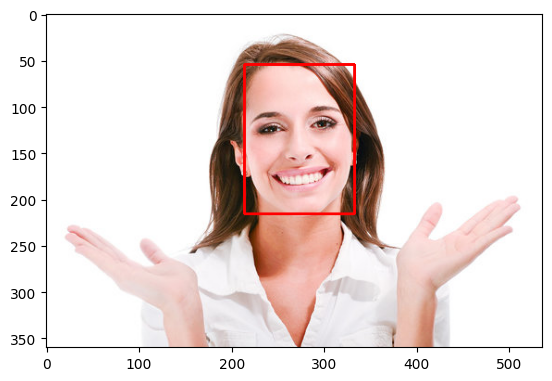

In [5]:
# On charge l'image et on la stocke dans une variable 
img = cv2.imread('images/test_joie.png', 1)

# On traite l'image pour changer ses couleurs
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# On détecte les visages dans l'image
rois = detector.detect_faces(img)

# Affichage d'un rectangle autour de chaque visage
for roi in rois:
    (x,y,w,h) = roi['box']
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255, 0, 0),2)

# Affichage de l'image 
plt.imshow(img)
pprint(rois)

MTCNN retourne une liste des ROI (regions of interest) - une par visage -  dans l'image. <br>

Chaque ROI est décrite sous la forme d'un dictionnaire ayant pour clés :
 - la bounding box correspondant à l'encadrement d'un visage
 - un indice de confiance
 - les points clés de l'image (yeux/nez/bouche).
 
Nous n'utiliserons pas ces derniers dans la suite, par contre les coordonnées de la bounding-box nous seront utiles. Elles nous permettront d'extraire la zone à analyser pour la reconnaissance de l'expression faciale, et d'encadrer le visage reconnu dans l'image interfacée.

### <a id='1'>Reconnaissance de l'expression faciale sur un flux vidéo avec MTCNN</a>

In [6]:
# Chargement des modèles 
recognator = models.load_model('ModelX')
# detector = MTCNN()

ValueError: File format not supported: filepath=ModelX. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(ModelX, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [ ]:
# On recupère les labels et le nombre de classes
tmp = os.listdir("data/train")
LABELS ={}
for clas, feeling in enumerate(tmp):
    LABELS[clas]=feeling
NUM_CLASS = len(tmp)

# Chargement des emojis
EMOJI = {
 0: cv2.imread('emojis/5-sad.png'),
 1: cv2.imread('emojis/6-surprise.png'),
 2: cv2.imread('emojis/3-happy.png'),
 3: cv2.imread('emojis/0-angry.png')
 }


In [ ]:
# Fonction de localisation des visages - modifications pour utilisation avec flux video filmant 1 seule personne
def localize_face(frame):
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    x, y, w, h = detector.detect_faces(image)[0]['box']
    while detector.detect_faces(image)[0]['confidence']>0.6 :
        cropped = image[y-10:y+h+10, x-10:x+w+10]
        gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray,(48,48)).astype('float') / 255
        localized = resized.reshape(1,48,48,1)
        return localized, [x, y, w, h]

In [ ]:
def detection_emotion():

    cam = cv2.VideoCapture(0)
    while True:
        ret_val, frame = cam.read()

        # Localisation des visages dans l'image
        face, box = localize_face(frame)
        
        # Reconnaissance de l'émotion
        emotion = np.argmax(recognator.predict(face))

        # Création d'une ROI pour l'affichage du smiley
        rows,cols,channels = EMOJI[0].shape
        roi_smiley = frame[0:rows, 0:cols]

        # Selon le résultat de la prédiction
        frame[0:rows, 0:cols ] = EMOJI[emotion]
 
        # Retourne l'image pour l'afficer en miroir
        frame = cv2.flip(frame, 1)
        
        # Affichage de l'image
        cv2.imshow('How are you ?', frame)
        
        # Pour quitter, appuyez sur la touche ESC
           
        if cv2.waitKey(1) == 27: 
            break 
    cam.release()
    cv2.destroyAllWindows()

Petit rappel, puisque le modèle a été entraîné avec des photos de face, pour la prise d'image par webcam, filmez-vous de face pour faciliter la détection.

In [ ]:
# Exécutez la cellule pour lancer la webcam
detection_emotion()